In [1]:
import glob
import random
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa
import librosa.display
import numpy as np
import os
import csv
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import os
import numpy as np
import scipy.io.wavfile
import scipy.fft
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.neural_network import MLPClassifier
import joblib
from imblearn.over_sampling import RandomOverSampler



C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
genres = []
path_audios = []
GENRE_DIR = 'genres_original/'
dirs = 'genres_original/*/*'
for i in glob.glob(dirs):
    if glob.glob(i)[0][-4:] == ".wav":
        path_audios.append(i,)
        genres.append([i][0].split("\\")[1].split(".")[0])
sample = dict(zip(genres, path_audios))
print(path_audios)
print(genres)

['genres_original\\blues\\blues.00000.wav', 'genres_original\\blues\\blues.00001.wav', 'genres_original\\blues\\blues.00002.wav', 'genres_original\\blues\\blues.00003.wav', 'genres_original\\blues\\blues.00004.wav', 'genres_original\\blues\\blues.00005.wav', 'genres_original\\blues\\blues.00006.wav', 'genres_original\\blues\\blues.00007.wav', 'genres_original\\blues\\blues.00008.wav', 'genres_original\\blues\\blues.00009.wav', 'genres_original\\blues\\blues.00010.wav', 'genres_original\\blues\\blues.00011.wav', 'genres_original\\blues\\blues.00012.wav', 'genres_original\\blues\\blues.00013.wav', 'genres_original\\blues\\blues.00014.wav', 'genres_original\\blues\\blues.00015.wav', 'genres_original\\blues\\blues.00016.wav', 'genres_original\\blues\\blues.00017.wav', 'genres_original\\blues\\blues.00018.wav', 'genres_original\\blues\\blues.00019.wav', 'genres_original\\blues\\blues.00020.wav', 'genres_original\\blues\\blues.00021.wav', 'genres_original\\blues\\blues.00022.wav', 'genres_or

Dans la cellule précédante, on crée une liste contenant les genres et une autre contenant les noms de fichiers , puis on crée un dictionaire qui combine les deux listes ayant le genre comme clés et les noms de fichiers comme diffèrentes valeurs pour les clés.

In [3]:
_, value = random.choice(list(sample.items()))
print(_)
ipd.Audio(value)

rock


Dans cette cellule, on choisit alèatoirement un audio depuis le data set et on affiche le genre et l'audio lui meme grace à IPython.display qui crée un objet audio à partir du chemin spécifié

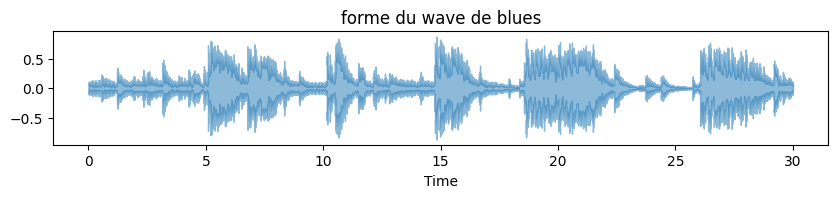

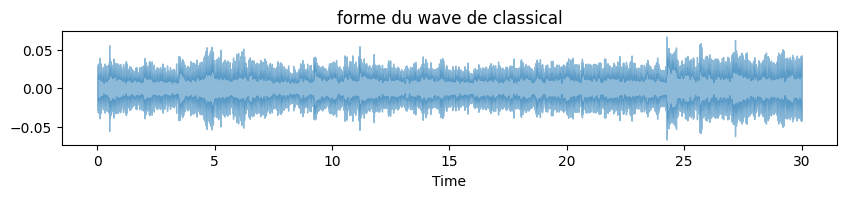

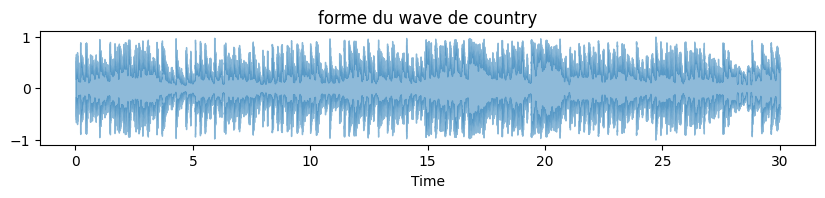

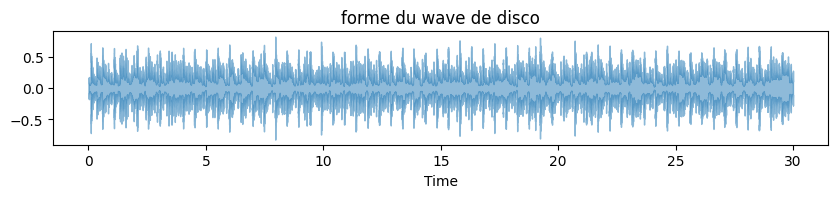

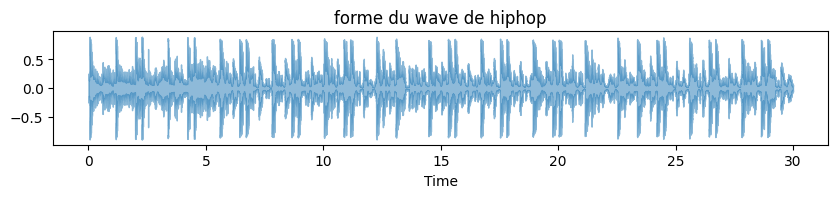

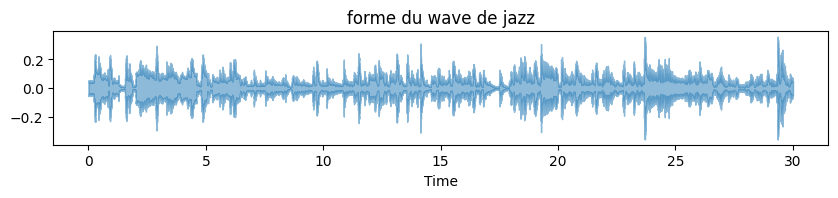

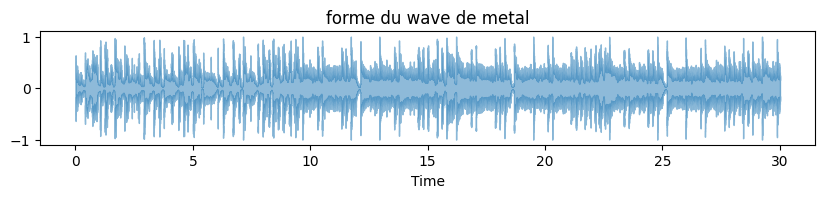

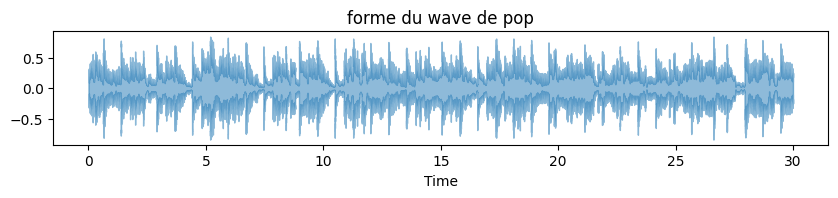

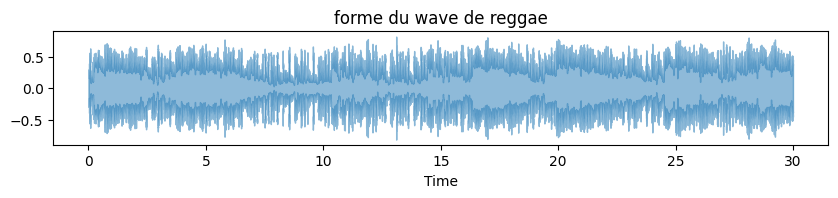

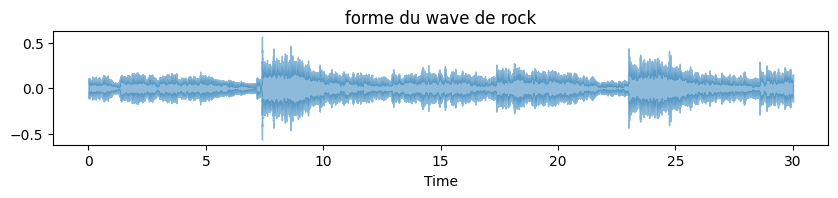

In [4]:
for genre, audio in sample.items():
    plt.figure(figsize=(10,5))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(librosa.load(audio)[0], alpha=0.5)
    plt.title("forme du wave de "+genre)

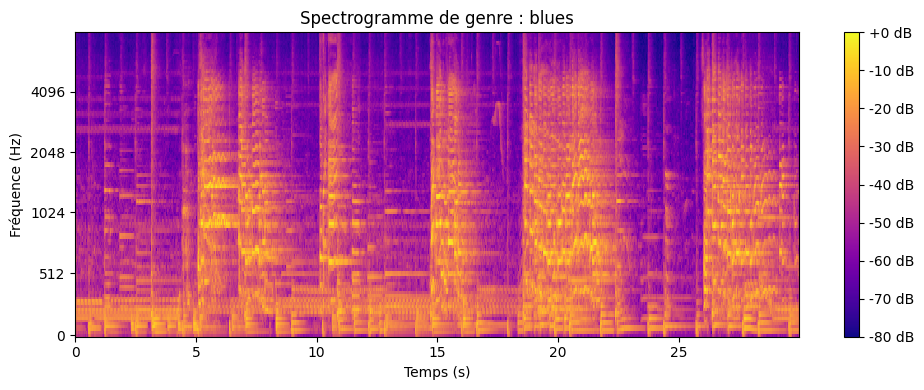

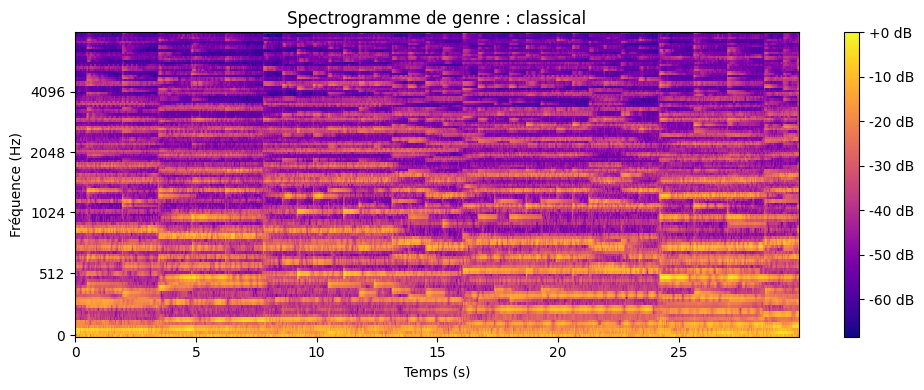

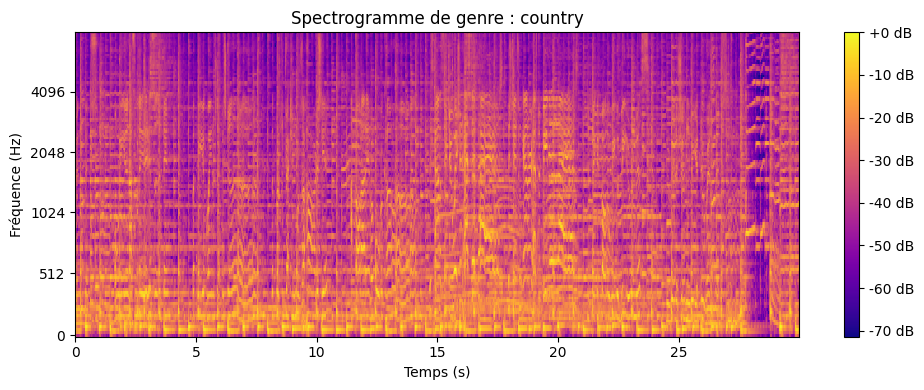

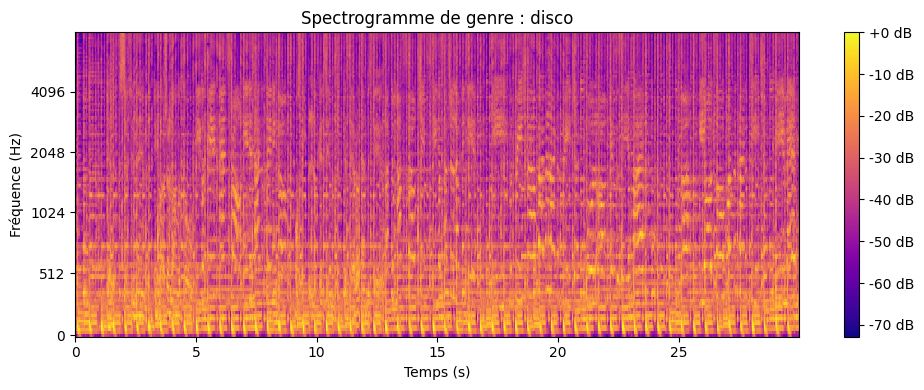

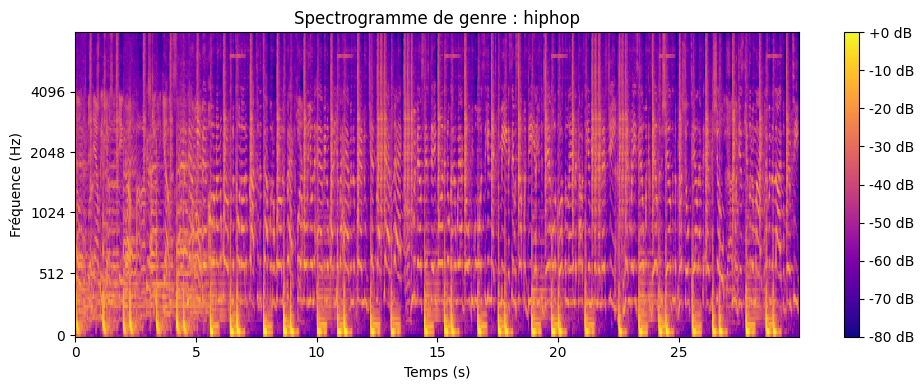

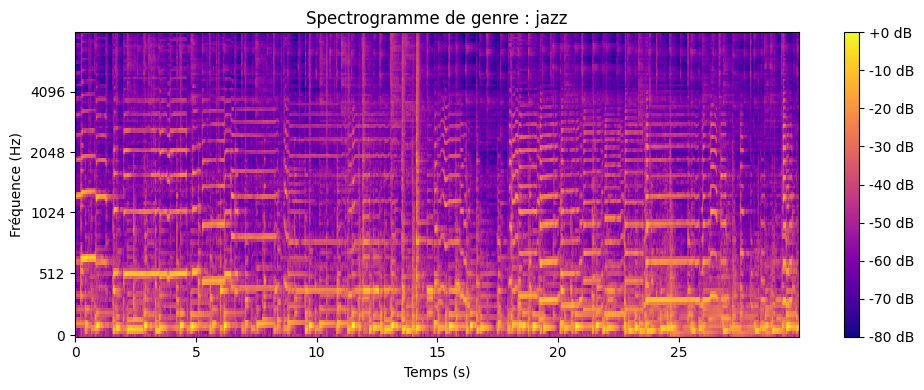

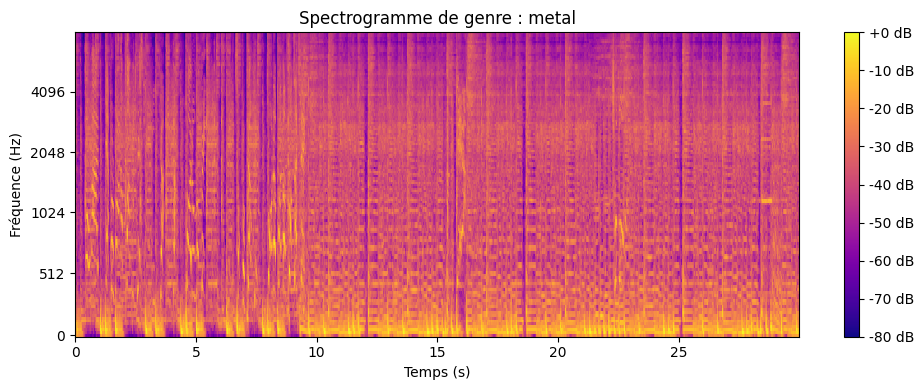

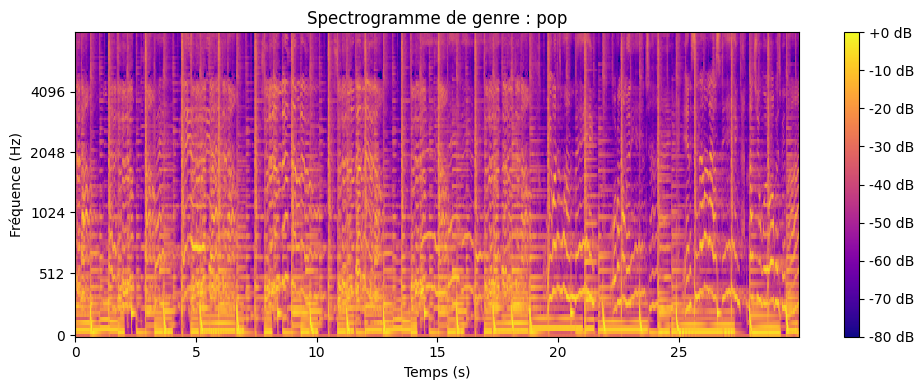

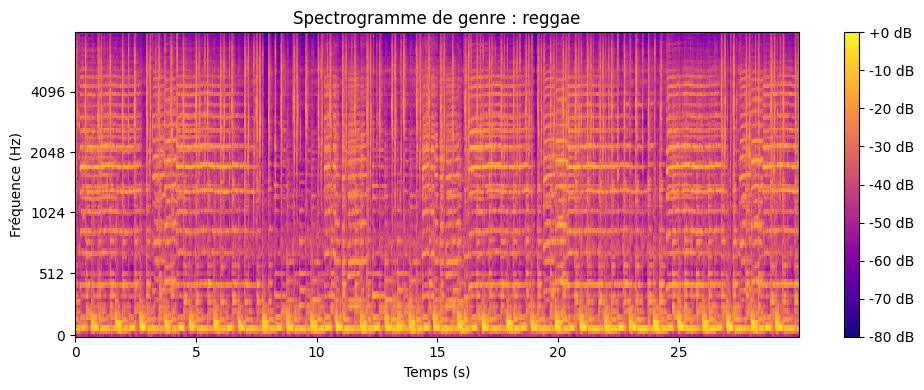

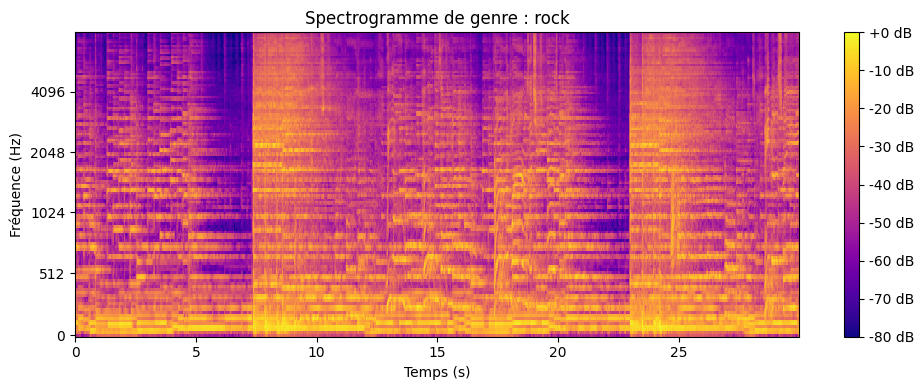

In [5]:
for genre,audio in sample.items():
    y, sr = librosa.load(audio, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convertir en décibels pour une meilleure visualisation

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='plasma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogramme de genre : {genre}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Fréquence (Hz)")
    plt.tight_layout()
    plt.show()


Cette cellule permet de visualiser les différents forme de vagues de chaque genre afin d'apercevoir leurs diffèrences grace à librosa.display.waveform().

In [6]:
data_csv = 'data.csv'
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 11):
    header += f' mfcc{i}'
for j in range(1, 11):
    header += f' rcep{j}'
header += ' label'
header = header.split()
file = open(data_csv, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

Création du dataset (nom,colonne,...) et génération des feautures

In [7]:
for genre in sample:
    for filename in os.listdir(f'genres_original/{genre}'):
         if filename.endswith('.wav'):
            songname = f'genres_original/{genre}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30) 
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)[:10]
            D = np.abs(librosa.stft(y))**2  # Spectrogramme de puissance
            log_spectrum = np.log(np.maximum(D, 1e-10))  # Éviter les log(0)
            rceps = np.real(np.fft.ifft(log_spectrum, axis=0))  # Transformée de Fourier inverse
            rceps_mean = np.mean(rceps[:10], axis=1)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            for j in rceps_mean:
                to_append += f' {j}' 
            to_append += f' {genre}'
            file = open(data_csv, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())


# librosa.load => retourne un tableau NumPy contenant les échantillons du signal audios et le taux d'échantillonag du fichier pour capturer le signal avec précision
# chroma_stft => calcule les intensités pour 12 classses de pitch (Do,Ré,Mi, ...)
# rms => tableau NumPy contenant les échantillons du signal audios et le taux d'échantillonag du fichier
# spectral Centroid => Mesure la brillance d'un son (aigus = centroide élevé)
# spectral bandwidth =>  Indique si le signal est concentré autour de certaines fréquences ou réparti sur une plage plus large.
# spectral Rolloff =>  Indique la limite des hautes fréquences et peut être utilisé pour distinguer les sons aigus et graves.
# Zero Crossing Rate => Indique  le caractère percussif d'un son.
# MFCC => représente l'énergie spectral sur échelle de Mel qui modèlise la perception humaine des fréquences.

In [6]:
data = pd.read_csv("data.csv")
data.head()

filename  chroma_stft      rmse  spectral_centroid  \
0  blues.00000.wav     0.349951  0.130192        1784.416546   
1  blues.00001.wav     0.340945  0.095892        1529.871314   
2  blues.00002.wav     0.363562  0.175494        1552.637786   
3  blues.00003.wav     0.404848  0.141139        1070.110059   
4  blues.00004.wav     0.308598  0.091540        1835.507008   

   spectral_bandwidth      rolloff  zero_crossing_rate       mfcc1  \
0         2002.657106  3806.418650            0.083066 -113.619385   
1         2038.612143  3548.986873            0.056044 -207.581512   
2         1747.382028  3041.089944            0.076301  -90.776344   
3         1596.244204  2185.061787            0.033309 -199.462006   
4         1748.367477  3581.003346            0.101500 -160.291855   

        mfcc2      mfcc3  ...     rcep2     rcep3     rcep4     rcep5  \
0  121.553032 -19.151056  ... -0.879468 -0.621238 -0.226620 -0.086683   
1  123.997147   8.939115  ... -0.804192 -0.498741 -0.091296  0.120637   
2  140.448608 -29.100559  ... -0.800873 -0.546544 -0.281394 -0.110855   
3  150.094727   5.649167  ... -0.535038 -0.413857 -0.127206  0.033868   
4  126.195770 -35.602501  ... -0.961486 -0.439554 -0.215765 -0.077548   

      rcep6     rcep7     rcep8     rcep9    rcep10  label  
0  0.047518  0.065428  0.015839 -0.011307  0.054352  blues  
1  0.144748  0.104427  0.097685  0.015691  0.052998  blues  
2 -0.010187  0.036898  0.017965  0.015519  0.039908  blues  
3  0.119486  0.089657  0.021931  0.030143  0.050251  blues  
4  0.008921  0.030031 -0.024469 -0.006408 -0.019522  blues  

[5 rows x 28 columns]

# cette fonction permet d'extraire les caractéristiques basées sur la Transformée de Fourier Rapide et les stocker dans des fichiers binaires Numpy ".npy" 

In [9]:
def create_fft(fn):
    if not os.path.exists(fn):
        return 
    sample_rate, X = scipy.io.wavfile.read(fn)
    if len(X.shape) > 1:
        X = X.mean(axis=1)
    fft_features = abs(scipy.fft.fft(X)[:20]) 
    base_fn, ext = os.path.splitext(fn)
    data_fn = base_fn + ".fft.npy"
    np.save(data_fn, fft_features)
audiofiles = pd.DataFrame(path_audios, columns=["files"])
audiofiles["files"].apply(create_fft) 

0      None
1      None
2      None
3      None
4      None
       ... 
394    None
395    None
396    None
397    None
398    None
Name: files, Length: 399, dtype: object

# Dans cette partie on va extraire les caractéristiques des audios puis l'ajouter à notre dataset

In [10]:
def add_fft_features(row, fft_dir):
    base_fn = os.path.splitext(os.path.basename(row["filename"]))[0]
    fft_file = glob.glob(os.path.join(fft_dir, "**", base_fn + ".fft.npy"), recursive=True)
    if fft_file:
        fft_features = np.load(fft_file[0])
        for i, value in enumerate(fft_features):
            row[f"fft_{i}"] = value
    return row
fft_dir = "genres_original"
dataset = pd.read_csv("data.csv")
dataset = dataset.apply(add_fft_features, fft_dir=fft_dir, axis=1)
dataset.to_csv("dataset_avec_fft.csv", index=False)

In [7]:
data = pd.read_csv("dataset_avec_fft.csv")
data.head()

filename  chroma_stft      rmse  spectral_centroid  \
0  blues.00000.wav     0.349951  0.130192        1784.416546   
1  blues.00001.wav     0.340945  0.095892        1529.871314   
2  blues.00002.wav     0.363562  0.175494        1552.637786   
3  blues.00003.wav     0.404848  0.141139        1070.110059   
4  blues.00004.wav     0.308598  0.091540        1835.507008   

   spectral_bandwidth      rolloff  zero_crossing_rate       mfcc1  \
0         2002.657106  3806.418650            0.083066 -113.619385   
1         2038.612143  3548.986873            0.056044 -207.581512   
2         1747.382028  3041.089944            0.076301  -90.776344   
3         1596.244204  2185.061787            0.033309 -199.462006   
4         1748.367477  3581.003346            0.101500 -160.291855   

        mfcc2      mfcc3  ...         fft_10         fft_11         fft_12  \
0  121.553032 -19.151056  ...  648204.765914  670495.000770  670910.316553   
1  123.997147   8.939115  ...  158959.361278  161342.599327  129933.790069   
2  140.448608 -29.100559  ...   47059.459394  213316.448960  119181.061109   
3  150.094727   5.649167  ...  115567.630529  111842.944780  111271.642212   
4  126.195770 -35.602501  ...   11443.872026    8382.193355   14307.256727   

          fft_13         fft_14         fft_15         fft_16         fft_17  \
0  318550.911109  597757.841690  889516.352723  594766.574826  589924.433235   
1   38176.879311   88755.521091  183123.740649  312101.650956  523192.456377   
2  123280.739407  214418.043608  140326.412234   40581.198224  209030.234374   
3   79887.768567   93222.818714   95745.545385  170670.952795  103382.582127   
4   19549.917903   27440.713622   27765.377660   27744.335232   29866.959529   

          fft_18         fft_19  
0  792986.509804  983871.033238  
1  383091.107116   61232.556453  
2   37745.961127  128976.215641  
3  127825.600319   92323.955469  
4   20085.854225    6339.053956  

[5 rows x 48 columns]

# On vérifie si notre dataset contient des valeurs manquantes ou pas

In [12]:
data.isnull().sum()


filename              0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
rcep1                 0
rcep2                 0
rcep3                 0
rcep4                 0
rcep5                 0
rcep6                 0
rcep7                 0
rcep8                 0
rcep9                 0
rcep10                0
label                 0
fft_0                 0
fft_1                 0
fft_2                 0
fft_3                 0
fft_4                 0
fft_5                 0
fft_6                 0
fft_7                 0
fft_8                 0
fft_9                 0
fft_10                0
fft_11                0
fft_12                0
fft_13          

On va maintenant convertire les classes en int pour travailler avec

In [9]:
data['label'] = data['label'].astype('category')
data['label_code'] = data['label'].cat.codes
lookup_genre_name = dict(enumerate(data['label'].cat.categories))
lookup_genre_name


{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [14]:
df_manual_testing =pd.DataFrame()
for label,group in data.groupby('label_code'):
    df_manual_testing = pd.concat([df_manual_testing, group.tail(2)], ignore_index=True)
    data.drop(group.tail(2).index,axis=0,inplace=True)
df_manual_testing.to_csv("manual_testing_dataset.csv")


In [11]:
x = data.drop(columns=['label','filename','label_code'], errors='ignore')
y = data['label_code']
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=3)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print(x_train_scaled)


[[ 0.79332948 -0.20037613  0.80797841 ... -0.27727789 -0.31408416
  -0.2936761 ]
 [-0.75592995 -1.1112404   1.01857373 ... -0.33862021 -0.46504917
  -0.37134578]
 [-0.0817445  -0.93056449 -0.19191334 ... -0.4271716  -0.46628563
  -0.45245421]
 ...
 [-0.70757272  0.18353095 -0.83834813 ... -0.44307688 -0.26423705
  -0.35347675]
 [ 1.10674695 -0.56762803  0.76105993 ... -0.46714399 -0.47063415
  -0.44693864]
 [ 0.11374932  0.60990431  0.37616694 ... -0.4071478   0.17094392
   0.1499201 ]]


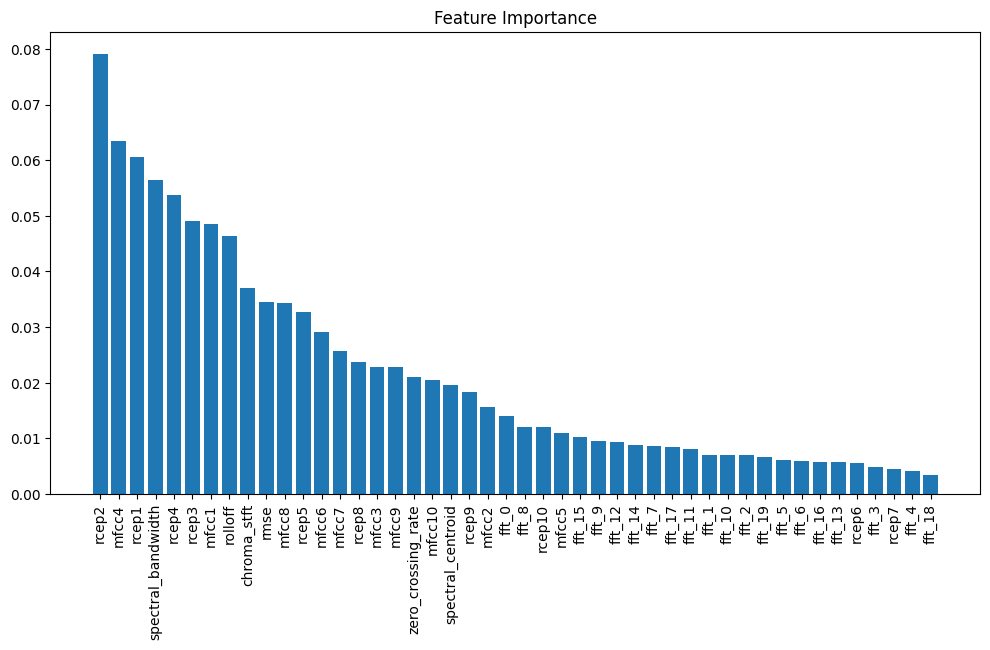

In [16]:

clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(x_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [x.columns.values[i] for i in indices]
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(x.shape[1]), importances[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

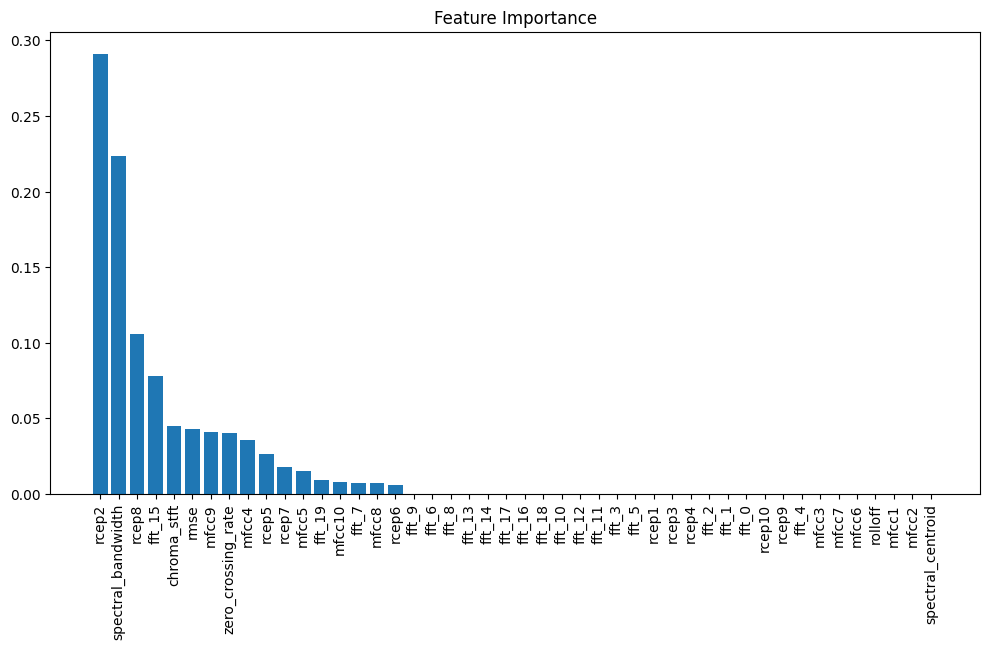

In [17]:
clf = DecisionTreeClassifier(random_state=0).fit(x_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [x.columns.values[i] for i in indices]
plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(range(x.shape[1]), importances[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

On remarque la différence d'importance des features selon le modèle choisit , or qu'avec DecisionTreeClassifier, l'importance est calculée pour un seul arbres tandis qu'avec RandomForestClassifier c'est sur plusieurs arbres càd que le résultat donné par RandomForestClassifier est plus robuste.

On va maintenant visualiser la distribution des features  les plus importantes en fonction des classes.

<Axes: xlabel='chroma_stft', ylabel='label'>

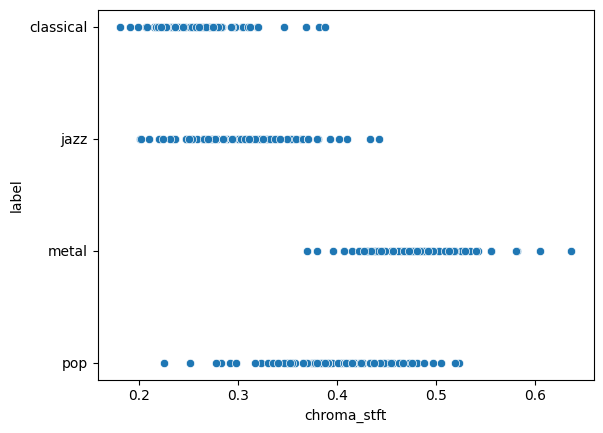

In [18]:
sns.scatterplot(x=x_train['chroma_stft'], y=data['label'])

<Axes: xlabel='rcep1', ylabel='label'>

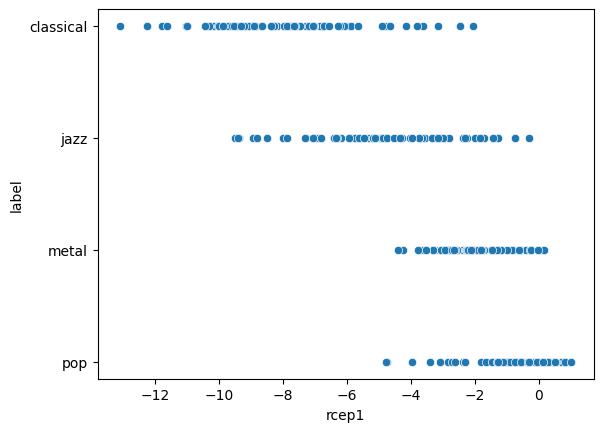

In [19]:
sns.scatterplot(x=x_train['rcep1'], y=data['label'])

<Axes: xlabel='rmse', ylabel='label'>

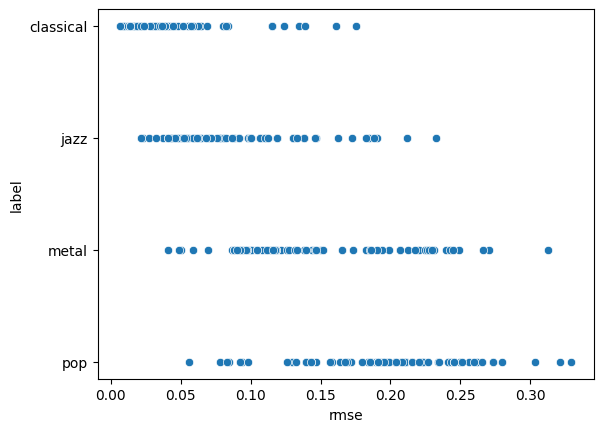

In [20]:
sns.scatterplot(x=x_train['rmse'],y=data['label'])

Aprés une bonne visualisation des données , on va maintenant passer aux différents modèles et leurs exactitude de prédiction

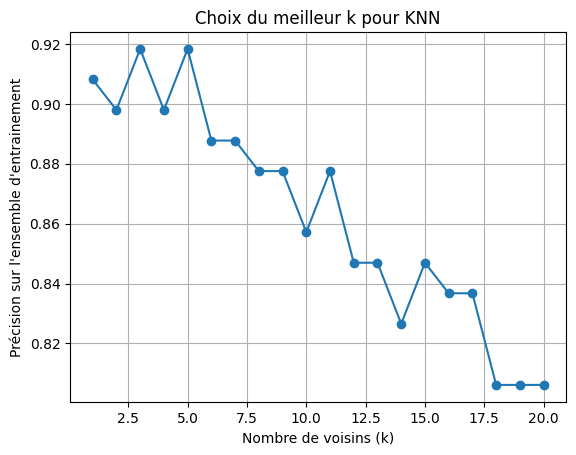

Le meilleur k est : 3


In [21]:
accuracies = []
for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)  # Entraîner sur les données d'entraînement
    y_val_pred = knn.predict(x_test)  # Prédire sur les données de validation
    acc = accuracy_score(y_test, y_val_pred)  # Calculer la précision
    accuracies.append(acc)

k_values= range(1,21)
# Visualisation des résultats
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel("Précision sur l'ensemble d'entrainement")
plt.title('Choix du meilleur k pour KNN')
plt.grid()
plt.show()

# Trouver le k optimal
best_k = k_values[accuracies.index(max(accuracies))]
print(f"Le meilleur k est : {best_k}")

# On entraine le modèle avec KNN

In [12]:
knn = KNeighborsClassifier(n_neighbors = 3,metric='euclidean',weights='distance')
knn.fit(x_train_scaled, y_train)
y_pre=knn.predict(x_test)
print(f"Accuracy :{accuracy_score(y_pre,y_test)}")


Accuracy :0.632


In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': range(4,50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Instancier le modèle
knn = KNeighborsClassifier()

# Grid Search
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(x_train_scaled, y_train)

# Meilleurs hyperparamètres
print(f"Best parameters for KNN: {grid_search_knn.best_params_}")

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
]
svm_model=SVC(probability=True)
svm = GridSearchCV( estimator=svm_model,param_grid= parameters, scoring = 'accuracy', cv=5)
svm.fit(x_train_scaled, y_train)
joblib.dump(svm.best_estimator_, 'models/model.pkl')
print("Meilleurs paramètres:", svm.best_params_)
print(f'Accuracy: {accuracy_score(svm.predict(x_test),y_test)}')


Meilleurs paramètres: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.9387755102040817


In [34]:

mlp = MLPClassifier(hidden_layer_sizes=(10), random_state=2)
mlp.fit(x_train_scaled,y_train)
joblib.dump(mlp, 'models/model.pkl')

y_pred=mlp.predict(x_test)
print(f'Accuracy: {accuracy_score(y_pred,y_test)}')


Accuracy: 0.9387755102040817


C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
def objective(trial):
    hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 50, 2000) 
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1) 
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2) 
    momentum = trial.suggest_uniform('momentum', 0.1, 0.9) 
    activation = trial.suggest_categorical('activation', ['logistic', 'relu', 'tanh'])
    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_sizes,),
        activation=activation,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        momentum=momentum
    )
    scores = cross_val_score(mlp, x_train_scaled, y_train, cv=5, scoring='accuracy')
    return scores.mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Meilleurs hyperparamètres :", study.best_params)



[I 2024-12-23 20:11:39,319] A new study created in memory with name: no-name-ace3d41e-699c-48c2-b87b-8f1af11d1e44


C:\Users\rimag\AppData\Local\Temp\ipykernel_8428\1109725186.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
C:\Users\rimag\AppData\Local\Temp\ipykernel_8428\1109725186.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
C:\Users\rimag\AppData\Local\Temp\ipykernel_8428\1109725186.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.1, 0.9)
[I 2024-12

Meilleurs hyperparamètres : {'hidden_layer_sizes': 292, 'learning_rate_init': 0.027988150604463226, 'alpha': 1.0463508065035577e-05, 'momentum': 0.6972556895313884, 'activation': 'tanh'}


In [28]:
# Réentraîner le modèle avec les meilleurs hyperparamètres
best_params = study.best_params
mlp = MLPClassifier(
    solver='adam',
    hidden_layer_sizes=(best_params['hidden_layer_sizes'],),
    activation=best_params['activation'],
    batch_size='auto',
    max_iter=10000,
    learning_rate_init=best_params['learning_rate_init'],
    alpha=best_params['alpha'],
    momentum=best_params['momentum'],
    random_state=7
)
mlp.fit(x_train_scaled, y_train)

# Évaluation sur les données de test
y_pred = mlp.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision sur les données de test : {accuracy:.4f}")

Précision sur les données de test : 0.9184


In [29]:
log=LogisticRegression(random_state=3)
log.fit(x_train_scaled,y_train)
y_predict=log.predict(x_test)
print(f'Accuracy: {accuracy_score(y_predict,y_test)}')

Accuracy: 0.9285714285714286


In [30]:
def objective(trial):
    solver=trial.suggest_categorical('solver',['newton-cg', 'sag', 'saga', 'lbfgs'])
    if solver in ['newton-cg', 'sag', 'lbfgs']:
        penalty = 'l2'
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l2', None])
    else:
        penalty = 'l2' 

    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    logReg = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C
    )
    score=cross_val_score(logReg,x_train_scaled,y_train,cv=5,scoring='accuracy')
    return score.mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Meilleurs hyperparamètres :", study.best_params)

[I 2024-12-23 20:19:38,525] A new study created in memory with name: no-name-fe49b50e-fd7d-4986-a781-67d8fd4cbebf
C:\Users\rimag\AppData\Local\Temp\ipykernel_8428\3722793148.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e4)
C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rimag\AppD

Meilleurs hyperparamètres : {'solver': 'saga', 'penalty': None, 'C': 0.020733473403460972}


In [33]:
best_log=LogisticRegression(solver='saga',penalty=None,C=0.020733473403460972)
best_log.fit(x_train_scaled,y_train)
y_predi=best_log.predict(x_test)
print(f'Accuracy: {accuracy_score(y_predi,y_test)}')

Accuracy: 0.9591836734693877


C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\rimag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
xboost= GradientBoostingClassifier(random_state=42, learning_rate = 0.75, max_depth = 2, n_estimators = 300)
xboost.fit(x_train_scaled,y_train)
y_boost=xboost.predict(x_test)
print(f"Accuracy: {accuracy_score(y_boost,y_test)}")

Accuracy: 0.8877551020408163
